In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from itertools import cycle
from keras import backend as K
from keras.layers import Activation
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [4]:
Trainpath = '/content/drive/MyDrive/is that santa/train'
Testpath = '/content/drive/MyDrive/is that santa/test'
x_Train = []
y_Train = []
x_Test = []
y_Test = []
label_name = {0: 'not-a-santa', 1: 'santa'}

In [5]:
print("Start data processing . . .")
for label, folder in label_name.items():
    path = os.path.join(Trainpath, folder)
    for img in os.listdir(path):
        imgtrain = cv2.imread(os.path.join(path, img))
        height, width = imgtrain.shape[:2]
        if height > width:
            new_height = 256
            new_width = int(width * (256 / height))
        else:
            new_width = 256
            new_height = int(height * (256 / width))
        imgtrain = cv2.resize(imgtrain, (new_width, new_height))
        top = (256 - new_height) // 2
        bottom = 256 - new_height - top
        left = (256 - new_width) // 2
        right = 256 - new_width - left
        imgtrain = cv2.copyMakeBorder(imgtrain, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0, 0))
        x_Train.append(imgtrain)
        y_Train.append(label)
print("Train data processing completed!")
for label, folder in label_name.items():
    path = os.path.join(Testpath, folder)
    for img in os.listdir(path):
        imgtest = cv2.imread(os.path.join(path, img))
        height, width = imgtest.shape[:2]
        if height > width:
            new_height = 256
            new_width = int(width * (256 / height))
        else:
            new_width = 256
            new_height = int(height * (256 / width))
        imgtest = cv2.resize(imgtest, (new_width, new_height))
        top = (256 - new_height) // 2
        bottom = 256 - new_height - top
        left = (256 - new_width) // 2
        right = 256 - new_width - left
        imgtest = cv2.copyMakeBorder(imgtest, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0, 0))
        x_Test.append(imgtest)
        y_Test.append(label)
print("Test data processing completed!")

Start data processing . . .
Train data processing completed!
Test data processing completed!


In [6]:
x_Train_array = np.array(x_Train)
x_Test_array = np.array(x_Test)
y_Train = np.array(y_Train)
y_Test = np.array(y_Test)
x_Train4D = x_Train_array.reshape(x_Train_array.shape[0], 256, 256, 3).astype('float32')
x_Test4D = x_Test_array.reshape(x_Test_array.shape[0], 256, 256, 3).astype('float32')
x_Train4D_normalize = x_Train4D / 255
x_Test4D_normalize = x_Test4D / 255
y_TrainOneHot = to_categorical(y_Train)
y_TestOneHot = to_categorical(y_Test)

In [7]:
# 創建 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # 將訓練資料的 20% 分為驗證集
)

# 創建 training generator
train_generator = train_datagen.flow_from_directory(
    directory=Trainpath,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # 指定為訓練集
)

# 創建 validation generator
validation_generator = train_datagen.flow_from_directory(
    directory=Trainpath,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # 指定為驗證集
)

train_generator_repeated = cycle(train_generator)


batch_size = 32
train_samples = train_generator.samples
validation_samples = validation_generator.samples
steps_per_epoch = train_samples / batch_size
validation_steps = validation_samples / batch_size

Found 838 images belonging to 2 classes.
Found 146 images belonging to 2 classes.


In [8]:
def leaky_relu(x):
    return K.relu(x, alpha=0.05) # alpha 為負值部分的斜率，可以調整

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(256, 256, 3)))
model.add(Activation(leaky_relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(Activation(leaky_relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation(leaky_relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(Activation(leaky_relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation(leaky_relu)) # 使用自定義的 Leaky ReLU 激活函數
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 最後一層仍然使用 softmax

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                   

In [9]:
train_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/50
26/26 [==============================] - 36s 1s/step - loss: 0.5876 - accuracy: 0.6969 - val_loss: 0.3252 - val_accuracy: 0.8630
Epoch 2/50
26/26 [==============================] - 33s 1s/step - loss: 0.3747 - accuracy: 0.8675 - val_loss: 0.3009 - val_accuracy: 0.8904
Epoch 3/50
26/26 [==============================] - 27s 1s/step - loss: 0.2886 - accuracy: 0.8902 - val_loss: 0.3607 - val_accuracy: 0.8356
Epoch 4/50
26/26 [==============================] - 25s 957ms/step - loss: 0.3215 - accuracy: 0.8819 - val_loss: 0.2318 - val_accuracy: 0.8973
Epoch 5/50
26/26 [==============================] - 26s 967ms/step - loss: 0.2674 - accuracy: 0.9057 - val_loss: 0.3617 - val_accuracy: 0.8425
Epoch 6/50
26/26 [==============================] - 26s 1s/step - loss: 0.2640 - accuracy: 0.9010 - val_loss: 0.2510 - val_accuracy: 0.8904
Epoch 7/50
26/26 [==============================] - 27s 1s/step - loss: 0.2813 - accuracy: 0.8783 - val_loss: 0.2731 - val_accuracy: 0.8836
Epoch 8/50
26/

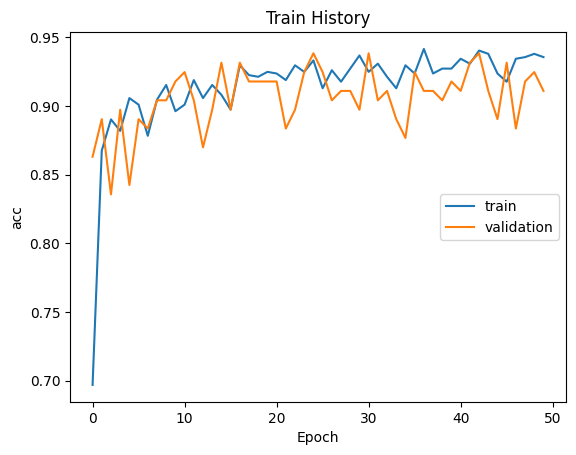

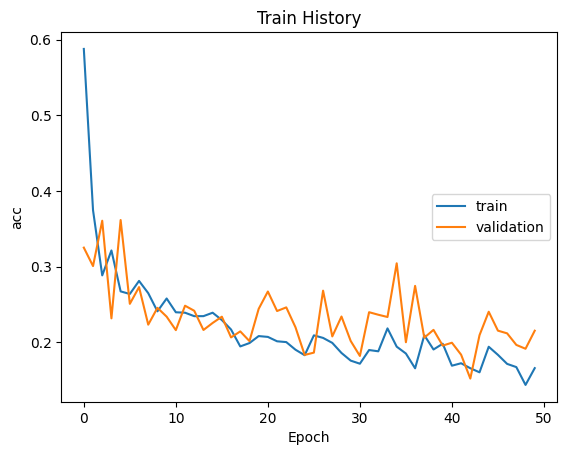

In [10]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [11]:
loss_train, accuracy_train = model.evaluate(train_generator, steps=steps_per_epoch)
print("\nTraining Accuracy: %.2f%%" % (accuracy_train * 100))

loss_val, accuracy_val = model.evaluate(validation_generator, steps=validation_steps)
print("\nValidation Accuracy: %.2f%%" % (accuracy_val * 100))

loss_test, accuracy_test = model.evaluate(x_Test4D_normalize, y_TestOneHot)
print("\nTest Accuracy: %.2f%%" % (accuracy_test * 100))

prediction = np.argmax(model.predict(x_Test4D_normalize), axis=1)
conf_matrix = confusion_matrix(np.argmax(y_TestOneHot, axis=1), prediction)
print("Confusion Matrix:")
print(conf_matrix)

26/26 [==============================] - 21s 794ms/step - loss: 0.1409 - accuracy: 0.9439

Training Accuracy: 94.39%
4/4 [==============================] - 5s 1s/step - loss: 0.2244 - accuracy: 0.9178

Validation Accuracy: 91.78%
8/8 [==============================] - 1s 89ms/step - loss: 0.8171 - accuracy: 0.7358

Test Accuracy: 73.58%
8/8 [==============================] - 0s 33ms/step
Confusion Matrix:
[[117   6]
 [ 59  64]]
